# Stress Detection
By Alexa Williams and Mia Procel

CPSC 322, Fall 2024

_________________________________________________

## INTRODUCTION
_____________________________
### Stress Detection Classifiers

The dataset used comes from a study that followed 100 people for 30 days and kept track of different aspects of their life that might contribute to stress. Their PSS levels were measured each day.

This notebook holds:

* Dummy Classifier
* kNN Classifier (k = 10)
* Naive Bayes Classifier
* Decision Tree Classifier 
* Random Forest Classifier

The classifiers are created using k-fold cross validation with (k = 10).

#### Our classifiers predict the discretized PSS_Score. The Random Forest Classifier performed the best.

In [1]:
import importlib
from tabulate import tabulate
import random
import pickle

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils
from mysklearn.myutils import run_all
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

stress_data = MyPyTable()
stress_data.load_from_file("cleaned_data.csv")

undiscretized_data = MyPyTable()
undiscretized_data.load_from_file("stress_detection.csv")

________________________

## DATA ANALYSIS
__________________________

Our dataset comes from a study that followed 100 people for 30 days and kept track of different aspects of their life that might contribute to stress. Their PSS scores were measured each day. PSS is a metric that measures stress from 0 to 40.It is classified as follows, 0 to 20 is a low score 20 to 27 is moderate and 27 to 40 is high. We used these values to discretize the data. Once we did, we found we had some class imbalances. The high classification had the most values the low had the second most values and moderate had the least. Moderate had about 600 values so we balanced the classes by removing instances of high and low to match the moderate. The values we chose to build our classifier on were “screen_on_time”, “num_sms”, “num_calls” and “sleep_time”. We discretized these values into three different categories, low moderate and high. We did it similar to what we did when we discretized the PSS score.

## Summary Statistics of the Stress Detection Data Before Discretization
* We used these summary statistics to decide how to discretize the data.

Summary Statistics: 
attribute                  min        max        mid        avg     median
-----------------  -----------  ---------  ---------  ---------  ---------
participant_id      1           100        50.5       50.5       50.5
day                 1            30        15.5       15.5       15.5
PSS_score          10            39        24.5       24.701     25
Openness            1.005         4.9974    3.0012     3.02066    3.05012
Conscientiousness   1.00098       4.99914   3.00006    3.00788    3.02206
Extraversion        1.00058       4.99764   2.99911    3.0021     2.98555
Agreeableness       1.00221       4.99988   3.00104    3.04766    3.09178
Neuroticism         1.00017       4.99641   2.99829    2.96359    2.94095
sleep_time          5.00329       8.99995   7.00162    7.00214    6.97822
wake_time           5.00193       8.99837   7.00015    6.99057    6.98226
sleep_duration      6.00056       8.99906   7.49981    7.47795    7.46342
PSQI_score          1        

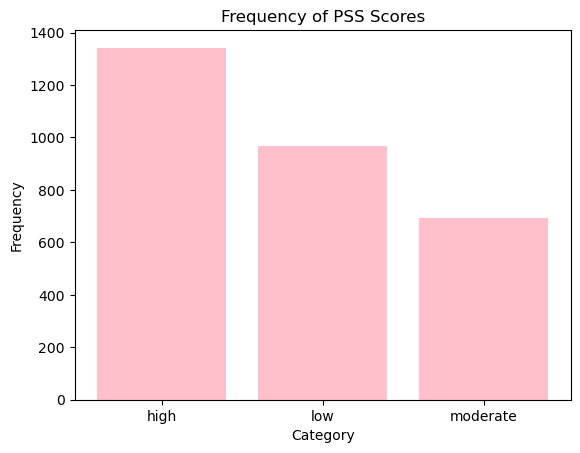

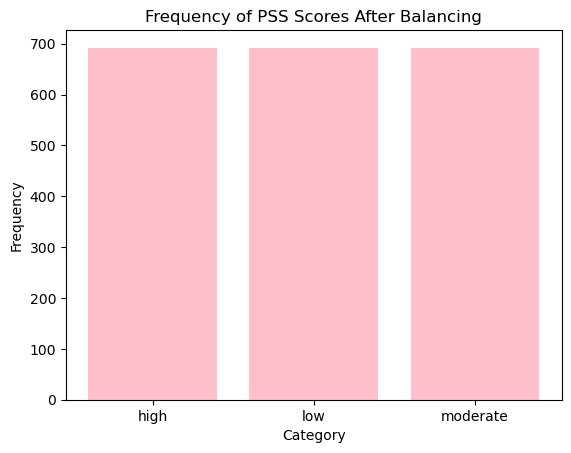

In [2]:
summary_statistics = undiscretized_data.compute_summary_statistics(undiscretized_data.column_names)
print("Summary Statistics: ")
summary_statistics.pretty_print()
run_all()

## Handling Class Imbalances


### Here we will randomly sample instances of the data to use for the classifier. This will eliminate the class imbalances that the dataset originally contained.

In [20]:
# delete 650 high
# delete 275 low
random.seed(0)
rows_with_high = [row for row in stress_data.data if row[2] == "high"]
rows_to_drop = random.sample(rows_with_high, k=650)
stress_data.data = [row for row in stress_data.data if row not in rows_to_drop]
rows_with_low = [row for row in stress_data.data if row[2] == "low"]
rows_to_drop = random.sample(rows_with_low, k=275)
stress_data.data = [row for row in stress_data.data if row not in rows_to_drop]

_________________________

## CLASSIFICATION RESULTS
________________________

### We develop the following classifiers in this section:

* Dummy Classifier
* kNN Classifier (k = 10)
* Naive Bayes Classifier
* Decision Tree Classifier 
* Random Forest Classifier

The classifiers are created using k-fold cross validation with (k = 10).

Each classifier's class is inspired by the corresponding SciKitLearn classifier.

### We test classifier accuracy using the following metrics:
* Accuracy
* Error rate
* Precision
* Recall
* F1 measure

In [21]:
X = [
    [
        row[15],  # screen_on_time
        row[14],  # num_sms
        row[13],  # num_calls
        row[8]    # sleep_time
    ]
    for row in stress_data.data
]
y = stress_data.get_column("PSS_score")
header = ["screen_on_time", "num_sms", "num_calls", "sleep_time"]
header_map = ["att0", "att1", "att2", "att3"]

knn_avg_acc, knn_error_rate, nb_avg_acc, nb_error_rate, knn_y_actual, knn_y_pred, nb_y_actual, nb_y_pred, knn_binary_ps, nb_binary_ps, knn_recall, nb_recall, knn_f1, nb_f1, dummy_avg_acc, dummy_error_rate, dummy_binary_ps, dummy_recall, dummy_f1, dummy_y_actual, dummy_y_pred = myutils.knn_nb_classifiers(X, y)
tree_avg_acc, tree_error_rate, tree_binary_ps, tree_recall, tree_f1, tree_y_actual, tree_y_pred = myutils.tree_classifier(X, y, header_map)
forest_avg_acc, forest_error_rate, forest_binary_ps, forest_recall, forest_f1, forest_y_actual, forest_y_pred, forest = myutils.forest_classifier(X, y)

print(f"Testing Classifiers with 10-Fold Cross Validation")
print("________________________")
print()
print(f"Naive Bayes Classifier: accuracy = {nb_avg_acc:.2f}, error rate = {nb_error_rate:.2f}, precision = {nb_binary_ps:.2f}, recall = {nb_recall:.2f}, F1 = {nb_f1:.2f},")
print()
print(f"k Nearest Neighbors Classifier: accuracy = {knn_avg_acc:.2f}, error rate = {knn_error_rate:.2f}, precision = {knn_binary_ps:.2f}, recall = {knn_recall:.2f}, F1 = {knn_f1:.2f},")
print()
print(f"Dummy Classifier: accuracy = {dummy_avg_acc:.2f}, error rate = {dummy_error_rate:.2f}, precision = {dummy_binary_ps:.2f}, recall = {dummy_recall:.2f}, F1 = {dummy_f1:.2f},")
print()
print(f"Decision Tree Classifier: accuracy = {tree_avg_acc:.2f}, error rate = {tree_error_rate:.2f}, precision = {tree_binary_ps:.2f}, recall = {tree_recall:.2f}, F1 = {tree_f1:.2f},")
print()
print(f"Random Forest Classifier: accuracy = {forest_avg_acc:.2f}, error rate = {forest_error_rate:.2f}, precision = {forest_binary_ps:.2f}, recall = {forest_recall:.2f}, F1 = {forest_f1:.2f},")

Testing Classifiers with 10-Fold Cross Validation
________________________

Naive Bayes Classifier: accuracy = 0.34, error rate = 0.66, precision = 0.33, recall = 0.45, F1 = 0.38,

k Nearest Neighbors Classifier: accuracy = 0.33, error rate = 0.67, precision = 0.32, recall = 0.34, F1 = 0.33,

Dummy Classifier: accuracy = 0.31, error rate = 0.69, precision = 0.31, recall = 0.37, F1 = 0.34,

Decision Tree Classifier: accuracy = 0.33, error rate = 0.67, precision = 0.33, recall = 0.33, F1 = 0.33,

Random Forest Classifier: accuracy = 0.35, error rate = 0.65, precision = 0.34, recall = 0.74, F1 = 0.47,


### Confusion Matrices

* The section below displays a confusion matrix for each classifier that we built to showcase the performance of each.

In [22]:
print("============================================================")
print("STEP 4: Confusion Matrices")
print("============================================================")
print()
labels = sorted(set(knn_y_actual) | set(knn_y_pred))
labels_strings = list(map(str, labels))
kNN_matrix = myevaluation.confusion_matrix(knn_y_actual, knn_y_pred, labels)
print("kNN Classifier (10-fold Cross Validation Confusion Matrix)")
print()
print("PSS_score")
print(tabulate(kNN_matrix, headers = labels_strings, showindex = labels_strings))
print()
print("------------------------------------------------------------")
print()
print("Dummy Classifier (10-fold Cross Validation Confusion Matrix)")
print()
print("PSS_score")
dummy_matrix = myevaluation.confusion_matrix(dummy_y_actual, dummy_y_pred, labels)
print(tabulate(dummy_matrix, headers = labels_strings, showindex = labels_strings))
print("------------------------------------------------------------")
print()
print("Naive Bayes Classifier (10-fold Cross Validation Confusion Matrix)")
print()
print("PSS_score")
labels = sorted(set(nb_y_actual) | set(nb_y_pred))
labels_strings = list(map(str, labels))
nb_matrix = myevaluation.confusion_matrix(nb_y_actual, nb_y_pred, labels)
print(tabulate(nb_matrix, headers = labels_strings, showindex = labels_strings))
print("------------------------------------------------------------")
print("Decision Tree Classifier (10-fold Cross Validation Confusion Matrix)")
print()
print("PSS_score")
labels = sorted(set(tree_y_actual) | set(tree_y_pred))
labels_strings = list(map(str, labels))
tree_matrix = myevaluation.confusion_matrix(tree_y_actual, tree_y_pred, labels)
print(tabulate(tree_matrix, headers = labels_strings, showindex = labels_strings))
print("------------------------------------------------------------")
print("------------------------------------------------------------")
print("Random Forest Classifier (10-fold Cross Validation Confusion Matrix)")
print()
print("PSS_score")
labels = sorted(set(forest_y_actual) | set(forest_y_pred))
labels_strings = list(map(str, labels))
forest_matrix = myevaluation.confusion_matrix(forest_y_actual, forest_y_pred, labels)
print(tabulate(forest_matrix, headers = labels_strings, showindex = labels_strings))
print("------------------------------------------------------------")

STEP 4: Confusion Matrices

kNN Classifier (10-fold Cross Validation Confusion Matrix)

PSS_score
            high    low    moderate
--------  ------  -----  ----------
high         237    214         241
low          249    199         244
moderate     250    186         255

------------------------------------------------------------

Dummy Classifier (10-fold Cross Validation Confusion Matrix)

PSS_score
            high    low    moderate
--------  ------  -----  ----------
high         258    288         146
low          282    262         148
moderate     290    281         120
------------------------------------------------------------

Naive Bayes Classifier (10-fold Cross Validation Confusion Matrix)

PSS_score
            high    low    moderate
--------  ------  -----  ----------
high         308     96         288
low          329     98         265
moderate     308     80         303
------------------------------------------------------------
Decision Tree Classifier (

### Performance Results:

After comparing the performance metrics for each classifier, it is clear to see the our random forest classifier performed the best overall! The dummy classifer was the worst classifier that we developed. The naive bayes, kNN, and decision tree classifiers all performed about the same right in the middle of the range. 

__________________________

## CLASSIFICATION WEB APP

_____________________________

* we pickle our random forest classifier here to be used in the stress_app.py file which deploys our local Flask app

In [23]:
packaged_obj = (header, forest)
outfile = open("forest.p", "wb")
pickle.dump(packaged_obj, outfile)
outfile.close()

_______________________________

## CONCLUSION

_____________________________

Our dataset comes from a study that followed 100 people for 30 days and kept track of different aspects of their life that might contribute to stress. Their PSS levels were measured each day.

First we had to discretize the data. For PSS_Score we used the following rules to discretize
* 0-20 = Low | 20-27 = Moderate | 27-40 = High

Then, the dataset had major class imbalances that we had to deal with. We randomly selected 650 rows of the "high" class to delete and 275 rows of the "low" class to delete to diminish any biases in our classifiers. 

We developed a Dummy Classifier, kNN Classifier (k = 10), Naive Bayes Classifier, Decision Tree Classifier, and Random Forest Classifier. The classifiers were evaluated using k-fold cross validation with (k = 10).

Overall, we learned that this data is not very adequate for predicting the PSS_Score of a person based on attributes such as "screen_on_time", "num_sms", "num_calls", and "sleep_time". However the random forest classifier had the best performance of all the classifiers we developed. It had an accuracy of 0.35, error rate of 0.65, precision of 0.34, recall of 0.74, and F1 of 0.47.

If we were to work to improve our classification results we would have spent more time on the random forest classifier. We would have made the ensemble by choosing a couple decision trees fit specifically for each individual class. This could potentially make the ensemble perform much better. Another way to imporve the classifier accuracy would be to add a pruning feature to our decision tree class. This would make each decision tree have a more desirable performance, and in tern it would improve the ensemble.

This project helps show that stress in not always easy to predict based on certain specific aspects of life. It can depend on many different things from person to person, and we cannot assume that two people with very similiar circumstances will feel the same PSS_Score.



___________________________________

## ACKNOWLEDGMENTS

______________________________

Dr. Sprint

Models based on scikit learn classifiers

ChatGPT for help conceptualizing how to set up our MyRandomForestClassifier class